Recurrent Neural Network 

Will Bartlett and David Whitmer 

Epoch [20/100], Loss: 0.1768
Epoch [40/100], Loss: 0.1573
Epoch [60/100], Loss: 0.0868
Epoch [80/100], Loss: 0.0225
Epoch [100/100], Loss: 0.0088

Training took 2.60 seconds

RNN Performance Metrics:
MSE: 0.9154
RMSE: 0.9567
MAE: 0.8108
R²: 0.6789


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Visualizations/RNN_Predictions.png'

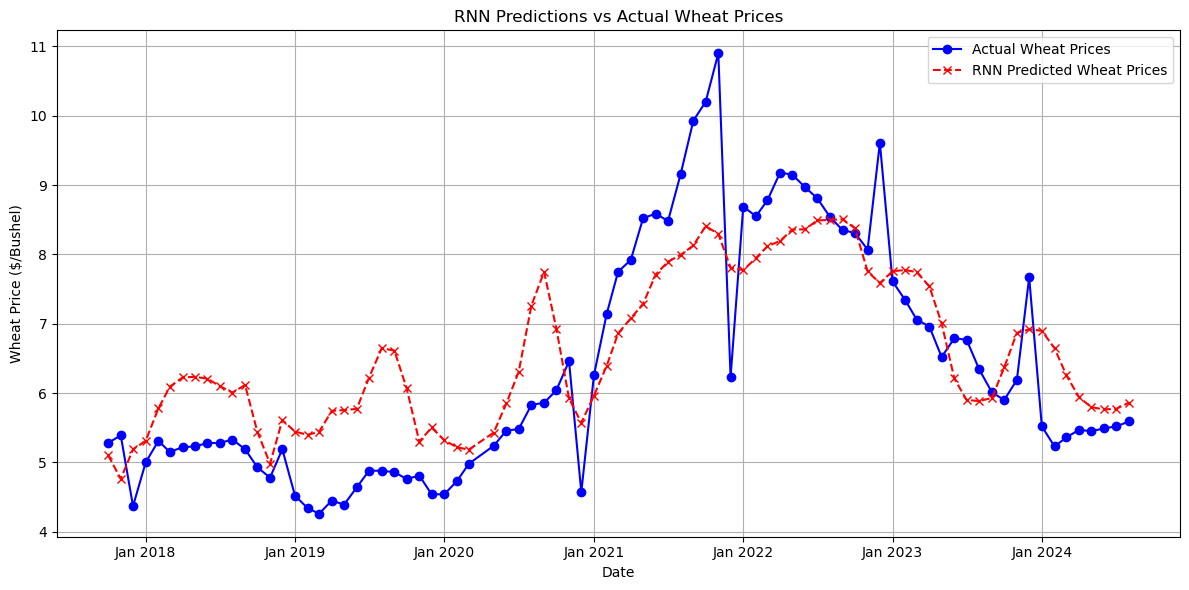

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time

# Load and preprocess data
df = pd.read_csv('Final_Data.csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Define target and features
y = df['wheat_price']
features = ['fertilizer_idx', 'avg_temp', 'drought_idx', 'cpi', 'commodity_imp_idx', 
            'commodity_exp_idx', 'flour_price', 'corn_price', 'crude_oil_price', 'year', 'month']
lag_periods = 6

# Create lagged features
X = pd.DataFrame()
for feature in features:
    for lag in range(1, lag_periods + 1):
        X[f'{feature}_lag{lag}'] = df[feature].shift(lag)
X = X.dropna()
y = y.iloc[lag_periods:]  # Align y with X after dropping NaNs

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = y.values.reshape(-1, 1)

# Create sequences for RNN
sequence_length = 6
X_seq, y_seq = [], []
for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i + sequence_length])
    y_seq.append(y_scaled[i + sequence_length])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X_seq) * 0.8)
X_train_seq = X_seq[:train_size]
X_test_seq = X_seq[train_size:]
y_train_seq = y_seq[:train_size]
y_test_seq = y_seq[train_size:]

# Get corresponding dates for test set
test_indices = range(train_size + sequence_length, len(X_seq) + sequence_length)
test_dates = df['date'].iloc[test_indices].reset_index(drop=True)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define RNN (LSTM) model
class WheatPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WheatPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = X_train_seq.shape[2]  # Number of features (11 features × 6 lags = 66)
hidden_size = 64
num_layers = 2
output_size = 1

# Initialize model, loss function, and optimizer
model = WheatPriceLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

training_time = time.time() - start_time
print(f"\nTraining took {training_time:.2f} seconds")

# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    rnn_pred = model(X_test_tensor).cpu().numpy()

# Calculate performance metrics
rnn_mse = mean_squared_error(y_test_seq, rnn_pred)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mae = mean_absolute_error(y_test_seq, rnn_pred)
rnn_r2 = r2_score(y_test_seq, rnn_pred)

print("\nRNN Performance Metrics:")
print(f"MSE: {rnn_mse:.4f}")
print(f"RMSE: {rnn_rmse:.4f}")
print(f"MAE: {rnn_mae:.4f}")
print(f"R²: {rnn_r2:.4f}")



# Plot predictions vs actual with dates on x-axis
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_seq, label='Actual Wheat Prices', color='blue', marker='o', linestyle='-')
plt.plot(test_dates, rnn_pred, label='RNN Predicted Wheat Prices', color='red', marker='x', linestyle='--')
plt.title('RNN Predictions vs Actual Wheat Prices')
plt.xlabel('Date')
plt.ylabel('Wheat Price ($/Bushel)')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Visualizations/RNN_Predictions.png')
plt.show()

The RNN's performance metrics (MSE: 0.9154, RMSE: 0.9567, MAE: 0.8108, R²: 0.6789) indicate moderate predictive accuracy, explaining 67.89% of the test set variance